In [1]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# for model prediction
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss, precision_recall_curve, brier_score_loss
from sklearn.model_selection import train_test_split, GridSearchCV

from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
import shap

# for feature processing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

In [619]:
import session_info
session_info.show()

# Challenge 1

Pear Inc wants you to understand what are the main traits separating the loyal employees from the others. Create a Jupyter notebook to answer their query. Gabriele is not an AI expert, so be sure to explain your results in a clear and simple way. However, you are also told that Fabio, an ML Engineer, will review your work: be sure to provide enough details to be useful for him.

In [513]:
df = pd.read_csv("../Data/churn.csv")

## Employee Churn Dataset
The dataset contains factors which may that influence a person's intention to leave its job.

It contains sociodemographic variables, as well as indicators of the past behaviour of each candidate.
All the data were collected in a short period of time and each person corresponds to a single sample in the dataset.

### Features

- enrollee_id: Unique ID for candidate 
- city: City code 
- city_development_index: Development index of the city (scaled)
- gender: Gender of candidate 
- relevant_experience: Relevant experience of candidate 
- enrolled_university: Type of University course enrolled if any 
- education_level: Education level of candidate 
- major_discipline: Education discipline of candidate 
- experience: Candidate total experience in years 
- company_size: Number of employees in last employer's company 
- company_type: Type of last employer 
- last_new_job: Difference in years between previous job and current job 
- training_hours: training hours completed 
- target: 0 – Not looking for job change, 1 – Looking for a job change

In [242]:
df.shape

(19158, 14)

In [243]:
# Check variable data types
df.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [244]:
# check statistics on continuos features
df.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [245]:
# check categorical features
df.nunique()

enrollee_id               19158
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   22
company_size                  8
company_type                  6
last_new_job                  6
training_hours              241
target                        2
dtype: int64

In [514]:
df['target'].value_counts()

target
0.0    14381
1.0     4777
Name: count, dtype: int64

Escludendo il target e "enrollee_id" che andra droppato, abbiamo 11 feature categoriche e 2 numeriche.

## DATA EXPLORATION 

In [246]:
df[df.duplicated()]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target


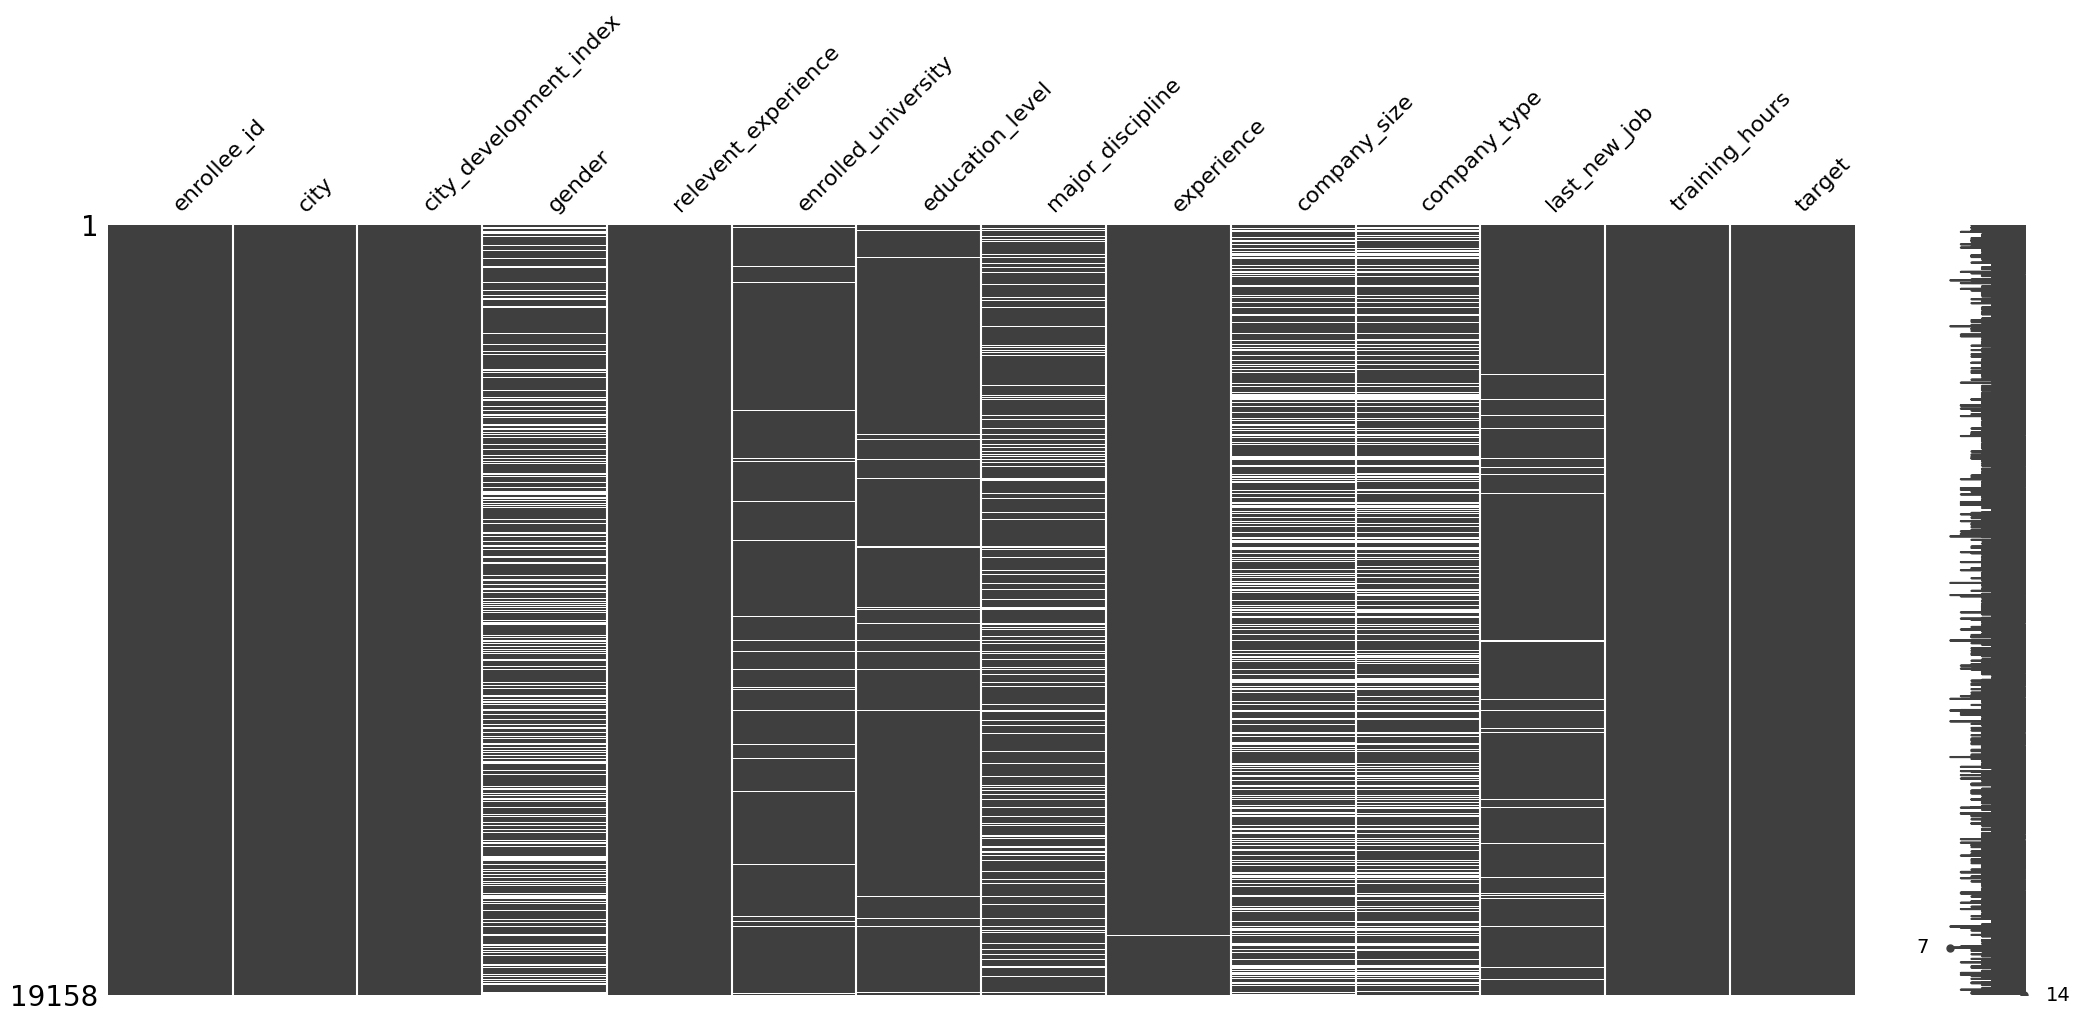

In [53]:
import missingno as msno

# Visualize missing values as a matrix
msno.matrix(df);

In [37]:
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [397]:
# Iniziamo cancellando le righe con troppi valori NaN
null_counts_per_row = df.isnull().sum(axis=1)

# Elimina le righe con 5 o più valori nulli
df = df[null_counts_per_row < 5]


In [398]:
df.shape

(18908, 14)

In [399]:
# we will fill with the "no_major"
df[df['education_level']=='Primary School']['major_discipline'].isna().sum()

300

In [400]:
# we only have nan as major_discipline for highschool 
df[df['education_level']=='High School']['major_discipline'].value_counts()

Series([], Name: count, dtype: int64)

In [401]:
# we will fill with the "no_major"
df[df['education_level']=='High School']['major_discipline'].isna().sum()

1963

In [402]:
# if education level and major_discipline is both missing  we will substitute with the minium level
df.loc[df['education_level'].isna()]['major_discipline'].isna().sum()


284

In [403]:
# for higher level of education we will fill nan with "other"
df.loc[df['major_discipline'].isna()]['education_level'].value_counts()

education_level
High School       1963
Primary School     300
Graduate            20
Masters              5
Name: count, dtype: int64

In [404]:
df['experience'].value_counts()

experience
>20    3269
5      1411
4      1381
3      1321
6      1204
2      1080
7      1023
10      985
9       976
8       795
15      683
11      662
14      586
1       526
16      505
<1      498
12      491
13      398
17      341
19      303
18      278
20      146
Name: count, dtype: int64

In [405]:
df['last_new_job'].value_counts() 

last_new_job
1        8004
>4       3279
2        2890
never    2351
4        1028
3        1021
Name: count, dtype: int64

In [406]:
df[df['company_type'].isna()]['last_new_job'].value_counts()

last_new_job
1        2397
never    1497
>4        724
2         697
4         220
3         206
Name: count, dtype: int64

In [407]:
df[df['company_type'].isna()]['experience'].value_counts()

experience
>20    904
4      560
3      557
2      501
5      484
6      371
7      316
<1     269
1      259
9      240
10     229
8      204
11     165
15     141
12     115
14     113
16     108
13      85
17      80
18      69
19      66
20      41
Name: count, dtype: int64

## DATA CLEANING

In [422]:
def print_normalized_groupby(df,columns):

    summed = df.groupby(columns)['target'].sum().reset_index()

    # Calcolare il conteggio delle osservazioni per ogni gruppo
    counts = df.groupby(columns)['target'].count().reset_index()

    normalized = pd.merge(summed, counts, on=columns)

    # Calcolare la proporzione normalizzata
    normalized['normalized_chrun_rate'] = normalized['target_x'] / normalized['target_y']
    normalized.columns = [columns, 'sum', 'count', 'normalized_chrun_rate']
    normalized_sorted = normalized.sort_values(by='normalized_chrun_rate', ascending=False)

    # Mostra il risultato
    return normalized_sorted


In [423]:
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

### Studiamo le features relevant_experience e experience

In [424]:
df[df['relevent_experience']=="No relevent experience"][['experience']].value_counts()

experience
3             682
2             647
4             580
5             495
>20           399
1             337
<1            335
6             322
7             266
9             200
10            175
8             166
11             99
15             98
14             87
12             60
13             55
16             51
19             40
17             28
18             27
20             15
Name: count, dtype: int64

In [425]:
df[df['relevent_experience']=="Has relevent experience"][['experience']].value_counts()

experience
>20           2870
5              916
6              882
10             810
4              801
9              776
7              757
3              639
8              629
15             585
11             563
14             499
16             454
2              433
12             431
13             343
17             313
19             263
18             251
1              189
<1             163
20             131
Name: count, dtype: int64

In [426]:
df[df.experience.isna()].isna().sum()

enrollee_id                0
city                       0
city_development_index     0
gender                    34
relevent_experience        0
enrolled_university        2
education_level            0
major_discipline           3
experience                46
company_size               8
company_type              17
last_new_job              15
training_hours             0
target                     0
dtype: int64

In [427]:
df[df.experience.isna()][['relevent_experience']].value_counts()

relevent_experience    
Has relevent experience    36
No relevent experience     10
Name: count, dtype: int64

In [428]:
df[df.experience.isna()][['target']].value_counts()

target
0.0       28
1.0       18
Name: count, dtype: int64

In [429]:
df.groupby(['experience'])['target'].sum().reset_index().sort_values(by='target',ascending=False)

,experience,target
21,>20,498.0
13,3,468.0
14,4,452.0
15,5,407.0
11,2,364.0
16,6,340.0
17,7,303.0
20,<1,232.0
0,1,226.0
19,9,213.0


dobbiamo normalizzare per il numero di osservazioni prima di poter osservare le statistiche.

In [430]:
print_normalized_groupby(df,'experience')


,experience,sum,count,normalized_chrun_rate
20,<1,232.0,498,0.465863
0,1,226.0,526,0.429658
13,3,468.0,1321,0.354277
11,2,364.0,1080,0.337037
14,4,452.0,1381,0.327299
17,7,303.0,1023,0.296188
15,5,407.0,1411,0.288448
16,6,340.0,1204,0.282392
18,8,195.0,795,0.245283
2,11,151.0,662,0.228097


In [431]:
df.groupby(['experience','relevent_experience'])['target'].sum().reset_index().sort_values(by='target',ascending=False)

,experience,relevent_experience,target
42,>20,Has relevent experience,426.0
27,3,No relevent experience,248.0
28,4,Has relevent experience,240.0
30,5,Has relevent experience,237.0
23,2,No relevent experience,236.0
32,6,Has relevent experience,231.0
26,3,Has relevent experience,220.0
29,4,No relevent experience,212.0
34,7,Has relevent experience,198.0
31,5,No relevent experience,170.0


### Abbiamo delle osservazioni con delle contradizioni tra le features "relevant_experience" e "experience" .

### Studiamo le features last_new_job, company_size, company_type.

In [432]:
df[['last_new_job','company_size','company_type']].isna().sum()

last_new_job     335
company_size    5695
company_type    5894
dtype: int64

In [433]:
df.groupby(['last_new_job'])['target'].sum().reset_index().sort_values(by='target',ascending=False)

,last_new_job,target
0,1,2109.0
5,never,723.0
1,2,698.0
4,>4,596.0
2,3,231.0
3,4,227.0


In [434]:
print_normalized_groupby(df,'last_new_job')

,last_new_job,sum,count,normalized_chrun_rate
5,never,723.0,2351,0.307529
0,1,2109.0,8004,0.263493
1,2,698.0,2890,0.241522
2,3,231.0,1021,0.226249
3,4,227.0,1028,0.220817
4,>4,596.0,3279,0.181763


In [435]:
print_normalized_groupby(df,'company_size')

,company_size,sum,count,normalized_chrun_rate
0,10/49,343.0,1469,0.233492
3,10000+,385.0,2018,0.190783
6,5000-9999,102.0,563,0.181172
4,50-99,545.0,3083,0.176776
5,500-999,152.0,877,0.173318
7,<10,223.0,1307,0.170620
1,100-500,415.0,2568,0.161604
2,1000-4999,200.0,1328,0.150602


In [436]:
print_normalized_groupby(df,'company_type')

,company_type,sum,count,normalized_chrun_rate
3,Other,29.0,121,0.239669
0,Early Stage Startup,142.0,603,0.235489
4,Public Sector,210.0,954,0.220126
2,NGO,97.0,521,0.186180
5,Pvt Ltd,1774.0,9814,0.180762
1,Funded Startup,140.0,1001,0.139860


 le features company_size e company_type sono statisticamente rilevanti, abbiamo tanti valori NaN, proviamo a recuperare qualche osservazione.

In [437]:
df.groupby(['last_new_job','company_size','company_type'])['target'].sum().reset_index().sort_values(by='target',ascending=False).head(30)

,last_new_job,company_size,company_type,target
25,1,50-99,Pvt Ltd,196.0
11,1,100-500,Pvt Ltd,134.0
19,1,10000+,Pvt Ltd,117.0
5,1,10/49,Pvt Ltd,108.0
171,>4,10000+,Pvt Ltd,73.0
53,2,100-500,Pvt Ltd,65.0
67,2,50-99,Pvt Ltd,62.0
15,1,1000-4999,Pvt Ltd,61.0
61,2,10000+,Pvt Ltd,58.0
41,1,<10,Pvt Ltd,55.0


In [438]:
df[df['last_new_job'].isna()]['company_type'].value_counts()

company_type
Pvt Ltd                121
Public Sector           19
Early Stage Startup     18
Funded Startup          10
NGO                      9
Other                    5
Name: count, dtype: int64

In [439]:
print(df[df['last_new_job']=='never']['company_type'].value_counts())
print("\nN NaN values: ")
print(df[df['last_new_job']=='never']['company_type'].isna().sum())

company_type
Pvt Ltd                700
Public Sector           52
Early Stage Startup     52
NGO                     23
Funded Startup          19
Other                    8
Name: count, dtype: int64

N NaN values: 
1497


In [440]:
print(df[df['last_new_job']=='never']['company_size'].value_counts())
print("\nN NaN values: ")
print(df[df['last_new_job']=='never']['company_size'].isna().sum())

company_size
50-99        133
10000+       113
<10          113
100-500       97
1000-4999     66
10/49         66
500-999       57
5000-9999     25
Name: count, dtype: int64

N NaN values: 
1681


In [441]:
print(df[df['last_new_job']=='never']['experience'].value_counts())
print("\nN NaN values: ")
print(df[df['last_new_job']=='never']['experience'].isna().sum())

experience
3      324
2      305
4      262
5      246
1      195
<1     160
6      159
7      130
>20    125
9       89
8       82
10      69
11      39
15      35
16      27
12      24
14      23
13      22
19      12
18      10
17       6
20       5
Name: count, dtype: int64

N NaN values: 
2


### Incongruenze nelle Feature Relative al Lavoro
Nell'analisi di quattro feature chiave - 'last_new_job', 'company_size', 'company_type', e 'experience' - emergono diverse incongruenze. Specificatamente, quando 'last_new_job' è impostato su 'never', ci si aspetterebbe che non ci siano informazioni disponibili riguardanti le dimensioni o il tipo dell'ultimo datore di lavoro (company_size e company_type); tuttavia, in alcune osservazioni queste sono effettivamente presenti. Questo suggerisce che il candidato ha avuto un impiego precedente, il che è in contrasto con il valore 'never'. Inoltre, la presenza di anni di esperienza nella feature 'experience' contraddice l'assenza di un ultimo lavoro, aggiungendo un ulteriore livello di contraddizione.

### Proveremo a fare pulizia su questi casi.

In [442]:
df[df['last_new_job']=='never'][['last_new_job','company_size','company_type','experience', 'relevent_experience']].head(30)

,last_new_job,company_size,company_type,experience,relevent_experience
2,never,NaN,NaN,5,No relevent experience
3,never,NaN,Pvt Ltd,<1,No relevent experience
10,never,NaN,NaN,2,No relevent experience
14,never,NaN,NaN,5,No relevent experience
16,never,50-99,Pvt Ltd,1,Has relevent experience
18,never,10000+,Pvt Ltd,7,Has relevent experience
25,never,NaN,NaN,4,No relevent experience
39,never,NaN,NaN,3,No relevent experience
43,never,50-99,Pvt Ltd,9,No relevent experience
45,never,NaN,NaN,5,No relevent experience


In [443]:
df[df['last_new_job'].isna()][['last_new_job','company_size','company_type','experience', 'relevent_experience']].head(30)

,last_new_job,company_size,company_type,experience,relevent_experience
58,NaN,10/49,Funded Startup,2,Has relevent experience
90,NaN,NaN,NaN,4,No relevent experience
180,NaN,5000-9999,NaN,5,No relevent experience
205,NaN,50-99,Pvt Ltd,5,Has relevent experience
575,NaN,50-99,Pvt Ltd,9,Has relevent experience
593,NaN,NaN,NaN,3,No relevent experience
719,NaN,NaN,NaN,11,Has relevent experience
770,NaN,50-99,NaN,5,Has relevent experience
891,NaN,100-500,NaN,3,Has relevent experience
902,NaN,50-99,Pvt Ltd,15,No relevent experience


In [444]:
df[df['company_size'].isna()][['last_new_job','company_size','company_type','experience', 'relevent_experience']].head(30)

,last_new_job,company_size,company_type,experience,relevent_experience
0,1,NaN,NaN,>20,Has relevent experience
2,never,NaN,NaN,5,No relevent experience
3,never,NaN,Pvt Ltd,<1,No relevent experience
5,1,NaN,NaN,11,Has relevent experience
10,never,NaN,NaN,2,No relevent experience
14,never,NaN,NaN,5,No relevent experience
19,1,NaN,NaN,4,Has relevent experience
22,1,NaN,NaN,10,Has relevent experience
25,never,NaN,NaN,4,No relevent experience
27,2,NaN,NaN,5,Has relevent experience


In [445]:
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4300
relevent_experience          0
enrolled_university        271
education_level            284
major_discipline          2572
experience                  46
company_size              5695
company_type              5894
last_new_job               335
training_hours               0
target                       0
dtype: int64

In [446]:
df_backup = df.copy()

In [447]:
df.shape

(18908, 14)

In [448]:
# Drop rows where 'last_new_job' is 'never', 'company_size' and 'company_type' are not null

df = df.drop(df[(df['last_new_job'] == 'never') & 
                         (df['company_size'].notnull()) & 
                         (df['company_type'].notnull())].index)


In [449]:
df.shape

(18315, 14)

In [450]:
# Conditions: 'last_new_job', 'company_size', and 'company_type' are null, and 'experience' is '<1' or NaN

df['experience'] = df['experience'].astype(str)  # Convert to string for comparison

# Apply the conditions and replace values
df.loc[(df['last_new_job'].isnull()) & (df['company_size'].isnull()) | 
       (df['company_type'].isnull()) & (df['experience'].isin(['<1', 'NaN', 'nan'])), 
       ['last_new_job', 'company_size', 'company_type']] = 'never'

# Apply the conditions and replace values
df.loc[(df['last_new_job']=="never") & (df['company_size'].isnull()) & 
       (df['company_type'].isnull()) & (df['experience'].isin(['<1', 'NaN', 'nan'])), 
       ['company_size', 'company_type']] = 'never'

# Conditions: 'last_new_job', 'company_size', and 'company_type' are null and 'relevant_experience' is 'No relevent experience'

# Apply the conditions and replace values
df.loc[(df['last_new_job'].isnull()) & (df['company_size'].isnull()) | 
       (df['company_type'].isnull()) & (df['relevent_experience'] == "No relevent experience"), 
       ['last_new_job', 'company_size', 'company_type', 'experience']] = 'never'
df.loc[df['experience'] == 'never', 'experience'] = '0'

In [451]:
# Conditions: 'last_new_job' is not 'never' and not null, and 'company_size' and 'company_type' are null

df.loc[(df['last_new_job'] != 'never') & (df['last_new_job'].notnull()) & 
       (df['company_size'].isnull()) & (df['company_type'].isnull()), 
       ['company_size', 'company_type']] = 'Missing'


In [452]:
# Apply the specified condition to replace null values in 'last_new_job' with "Missing"
# Condition: 'company_size' and 'company_type' are not null

df.loc[(df['company_size'].notnull()) & (df['company_type'].notnull()) & 
       (df['last_new_job'].isnull()), 'last_new_job'] = 'Missing'



In [453]:
# Apply the specified condition to replace null values in 'company_size' with "Missing"
# Condition: 'company_size' is null, 'last_new_job' is not 'never' and is not null, 
# and 'company_type' is not null

df.loc[(df['company_size'].isnull()) & (df['last_new_job'] != 'never') & 
       (df['last_new_job'].notnull()) & (df['company_type'].notnull()), 'company_size'] = 'Missing'

df.loc[(df['company_type'].isnull()) & (df['last_new_job'] != 'never') & 
       (df['last_new_job'].notnull()) & (df['company_size'].notnull()), 'company_type'] = 'Missing'



In [454]:
# Apply the specified condition to replace 'last_new_job' with "Missing"
# Condition: 'company_size' and 'company_type' are not null, 
# 'relevent_experience' is "Has relevent experience", and 'experience' is not '0', '<1', or '1'

df.loc[(df['company_size'].notnull()) & (df['company_type'].notnull()) &
       (df['relevent_experience'] == "Has relevent experience") &
       (~df['experience'].isin(['0', '<1', '1'])), 'last_new_job'] = 'Missing'



In [455]:
# Apply the specified condition to set 'last_new_job' to "Missing"
# Condition: 'last_new_job' is null, one of 'company_size' or 'company_type' is not null, 
# 'experience' is between '5' and '>20', and 'relevent_experience' is "Has relevent experience"

# Convert 'experience' to a numeric format for comparison, treating '>20' as 21
df['experience'] = df['experience'].replace({'>20': 21})
df['experience'] = df['experience'].replace({'<1': 0}).astype(float)

df.loc[(df['last_new_job'].isnull()) & 
                ((df['company_size'].notnull()) | (df['company_type'].notnull())) &
                (df['experience'] >= 5) & 
                (df['relevent_experience'] == "Has relevent experience"), 
                'last_new_job'] = 'Missing'



In [456]:
df.shape

(18315, 14)

In [457]:
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4138
relevent_experience          0
enrolled_university        260
education_level            274
major_discipline          2495
experience                  45
company_size               425
company_type               238
last_new_job                 8
training_hours               0
target                       0
dtype: int64

In [458]:
# Drop all rows with any null values among 'last_new_job', 'company_size', 'company_type', 
# 'experience', and 'relevent_experience'

columns_to_check = ['last_new_job', 'company_size', 'company_type', 'experience', 'relevent_experience']
df = df.dropna(subset=columns_to_check)

In [459]:
df.shape

(17771, 14)

In [460]:
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    3951
relevent_experience          0
enrolled_university        239
education_level            248
major_discipline          2312
experience                   0
company_size                 0
company_type                 0
last_new_job                 0
training_hours               0
target                       0
dtype: int64

### Studiamo gender

In [461]:
df.groupby(['gender'])['target'].sum().reset_index().sort_values(by='target',ascending=False)

,gender,target
1,Male,2825.0
0,Female,308.0
2,Other,46.0


In [462]:
print_normalized_groupby(df,'gender')

,gender,sum,count,normalized_chrun_rate
2,Other,46.0,168,0.273810
0,Female,308.0,1181,0.260796
1,Male,2825.0,12471,0.226526


difficile da riempire, droppiamo gender

In [463]:
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

### Studiamo Major_discipline, education_level, enrolled_university

In [464]:
df[['education_level','enrolled_university','major_discipline']].isna().sum()

education_level         248
enrolled_university     239
major_discipline       2312
dtype: int64

In [465]:
df[df['major_discipline'].isna()][['target']].value_counts()

target
0.0       1858
1.0        454
Name: count, dtype: int64

In [466]:
df[df['major_discipline'].isna()][['education_level','enrolled_university']].isna().sum()

education_level        248
enrolled_university     40
dtype: int64

In [467]:
df[['enrolled_university']].value_counts()

enrolled_university
no_enrollment          13004
Full time course        3401
Part time course        1127
Name: count, dtype: int64

In [468]:
df[['education_level']].value_counts()

education_level
Graduate           10950
Masters             4142
High School         1781
Phd                  391
Primary School       259
Name: count, dtype: int64

In [469]:
df[['major_discipline']].value_counts()

major_discipline
STEM                13688
Humanities            649
Other                 357
Business Degree       312
Arts                  242
No Major              211
Name: count, dtype: int64

In [470]:
df[df['major_discipline'].isna()][['education_level']].value_counts()

education_level
High School        1781
Primary School      259
Graduate             20
Masters               4
Name: count, dtype: int64

In [471]:
df[df['major_discipline']=="No Major"][['education_level']].value_counts()

education_level
Graduate           186
Masters             25
Name: count, dtype: int64

In [472]:
wrong_rows = df[(df['major_discipline'] == "No Major") & (df['education_level'].isin(['Graduate', 'Masters']))]

# Rimuoviamo queste righe
df = df.drop(wrong_rows.index)


In [473]:
df[df['education_level']=="Primary School"][['major_discipline']].isna().sum()

major_discipline    259
dtype: int64

In [474]:
# primary school non ha major
df.loc[(df['education_level'] == 'Primary School'), 'major_discipline'] = 'No Major'

In [475]:
df[df['major_discipline']!="No Major"][['education_level']].value_counts()

education_level
Graduate           10764
Masters             4117
High School         1781
Phd                  391
Name: count, dtype: int64

In [476]:
df[df['major_discipline']!="No Major"][['enrolled_university']].value_counts()

enrolled_university
no_enrollment          12609
Full time course        3355
Part time course        1106
Name: count, dtype: int64

In [477]:
df[df['education_level']=="Primary School"][['enrolled_university']].value_counts()

enrolled_university
no_enrollment          218
Full time course        27
Part time course         8
Name: count, dtype: int64

In [478]:
# rimuovo le righe in cui educazione è primary school ma frecquentano corso universitario
wrong_rows = df[(df['education_level'] == "Primary School") & (df['enrolled_university'].isin(['Full time course', 'Part time course']))]

# Rimuovi queste righe
df = df.drop(wrong_rows.index)


In [479]:
df[['education_level','enrolled_university','major_discipline']].isna().sum()

education_level         248
enrolled_university     237
major_discipline       2053
dtype: int64

In [480]:
df[df['major_discipline'].isna()][['enrolled_university']].value_counts()

enrolled_university
no_enrollment          1028
Full time course        820
Part time course        171
Name: count, dtype: int64

In [481]:
df[df['major_discipline'].isna()][['target']].value_counts()

target
0.0       1632
1.0        421
Name: count, dtype: int64

In [482]:
print_normalized_groupby(df,'major_discipline')

,major_discipline,sum,count,normalized_chrun_rate
1,Business Degree,83.0,312,0.266026
5,STEM,3543.0,13688,0.258840
4,Other,92.0,357,0.257703
0,Arts,51.0,242,0.210744
2,Humanities,136.0,649,0.209553
3,No Major,22.0,224,0.098214


In [483]:
df[df['education_level']=="Graduate"][['major_discipline']].value_counts()

major_discipline
STEM                9657
Humanities           407
Other                256
Business Degree      226
Arts                 198
Name: count, dtype: int64

In [484]:
print_normalized_groupby(df,'education_level')

,education_level,sum,count,normalized_chrun_rate
0,Graduate,2979.0,10764,0.276756
2,Masters,877.0,4117,0.213019
1,High School,359.0,1781,0.201572
3,Phd,58.0,391,0.148338
4,Primary School,22.0,224,0.098214


In [485]:
df[df['enrolled_university'].isna()]['target'].value_counts()

target
0.0    143
1.0     94
Name: count, dtype: int64

In [486]:
# Check for rows with null values in 'enrolled_university', 'education_level', and 'major_discipline'
null_counts = df[['enrolled_university', 'education_level', 'major_discipline']].isnull().all(axis=1).sum()

# Display the count of such rows
null_counts


9

In [395]:
df[df[['enrolled_university', 'education_level', 'major_discipline']].isnull().all(axis=1)]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
13,5826,city_21,0.624,Male,No relevent experience,NaN,NaN,NaN,0.0,never,never,never,24,0.0
171,12384,city_70,0.698,NaN,Has relevent experience,NaN,NaN,NaN,21.0,Missing,Missing,Missing,33,0.0
366,604,city_16,0.910,Male,No relevent experience,NaN,NaN,NaN,0.0,never,never,never,24,0.0
399,23901,city_103,0.920,Male,No relevent experience,NaN,NaN,NaN,0.0,never,never,never,32,0.0
479,15279,city_103,0.920,NaN,No relevent experience,NaN,NaN,NaN,0.0,never,never,never,30,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17950,5918,city_165,0.903,NaN,No relevent experience,NaN,NaN,NaN,0.0,never,never,never,84,0.0
17977,18594,city_134,0.698,NaN,Has relevent experience,NaN,NaN,NaN,21.0,never,never,Missing,51,0.0
18259,19455,city_76,0.698,Male,No relevent experience,NaN,NaN,NaN,0.0,never,never,never,41,0.0
18343,15834,city_104,0.924,NaN,No relevent experience,NaN,NaN,NaN,0.0,never,never,never,30,0.0


In [487]:
df = df.drop(df[df[['enrolled_university', 'education_level', 'major_discipline']].isnull().all(axis=1)].index)

In [488]:
df[['enrolled_university','education_level','major_discipline']].head(30)

,enrolled_university,education_level,major_discipline
0,no_enrollment,Graduate,STEM
1,no_enrollment,Graduate,STEM
2,Full time course,Graduate,STEM
4,no_enrollment,Masters,STEM
5,Part time course,Graduate,STEM
6,no_enrollment,High School,NaN
7,no_enrollment,Graduate,STEM
8,no_enrollment,Graduate,STEM
9,no_enrollment,Graduate,STEM
10,Full time course,High School,NaN


In [489]:
df.shape

(17516, 14)

In [490]:
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    3895
relevent_experience          0
enrolled_university        228
education_level            239
major_discipline          2044
experience                   0
company_size                 0
company_type                 0
last_new_job                 0
training_hours               0
target                       0
dtype: int64

In [494]:
df[df['education_level'].isna()]['target'].value_counts()

target
0.0    190
1.0     49
Name: count, dtype: int64

In [495]:
df[df['enrolled_university'].isna()]['target'].value_counts()

target
0.0    138
1.0     90
Name: count, dtype: int64

In [497]:
# Count the number of rows that would be lost if dropping nulls in 'education_level' and 'enrolled_university'
rows_lost = df[df['education_level'].isnull() | df['enrolled_university'].isnull()].shape[0]

# Count the number of 'target' values that would be lost
targets_lost = df[df['education_level'].isnull() | df['enrolled_university'].isnull()]['target'].sum()

rows_lost, targets_lost


(467, 139.0)

In [499]:
df = df.fillna("Missing")

In [498]:
df.shape

(17516, 14)

### Studiamo le features numeriche 

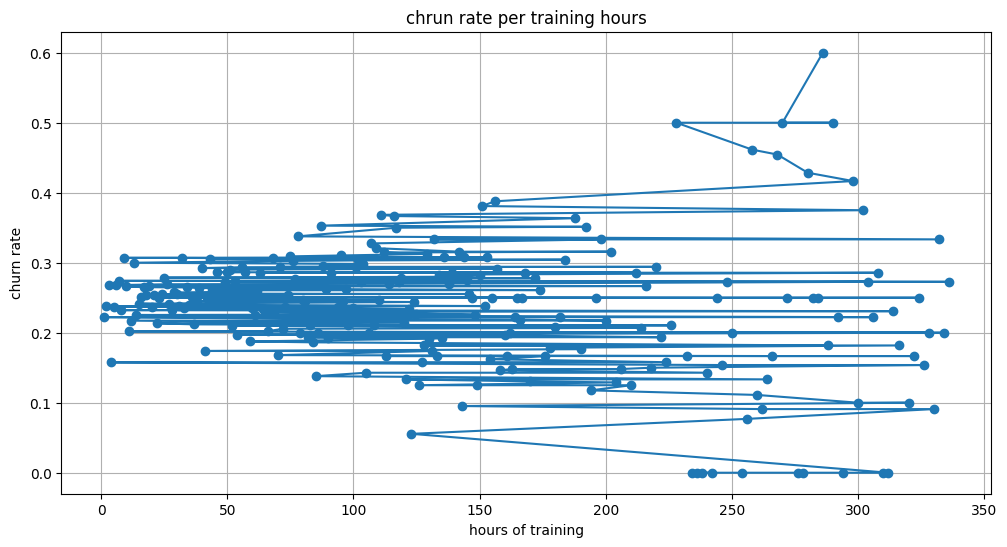

In [503]:
normalized_df= print_normalized_groupby(df,'training_hours')

# Plottare i dati normalizzati
plt.figure(figsize=(12, 6))
plt.plot(normalized_df['training_hours'], normalized_df['normalized_chrun_rate'], marker='o')
plt.title(f'chrun rate per training hours')
plt.xlabel("hours of training")
plt.ylabel('churn rate')
plt.grid(True)
plt.show()

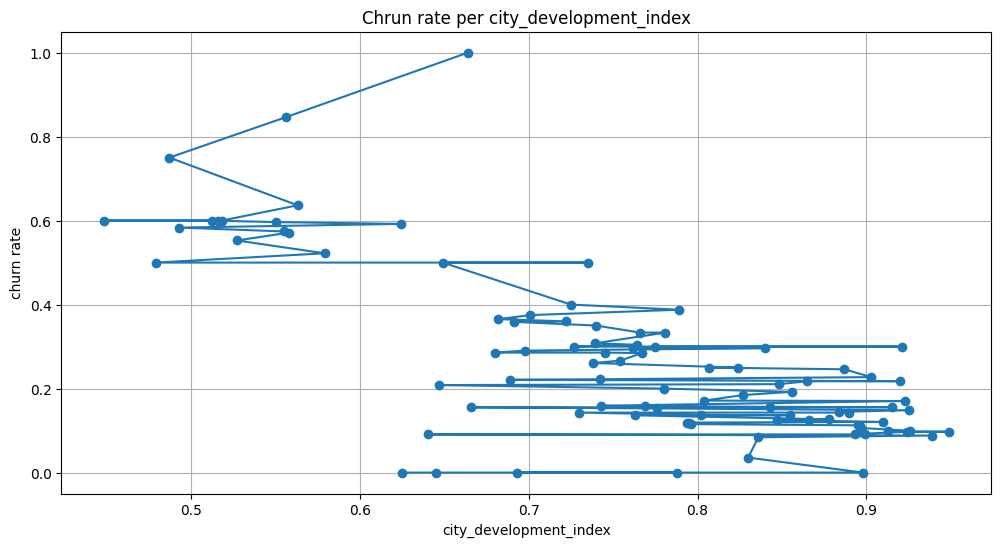

In [504]:

normalized_df= print_normalized_groupby(df,'city_development_index')

# Plottare i dati normalizzati
plt.figure(figsize=(12, 6))
plt.plot(normalized_df['city_development_index'], normalized_df['normalized_chrun_rate'], marker='o')
plt.title(f'Chrun rate per city_development_index')
plt.xlabel("city_development_index")
plt.ylabel('churn rate')
plt.grid(True)
plt.show()

abbiamo individuato due cluster chiari, dove chi vive in una città con indice di sviluppo alto ha meno probabilità di fare churn, al contrario chi vive in una città con indice di sviluppo basso ha più probabilità di fare churn

In [505]:
print_normalized_groupby(df,'city').sort_values(by='count',ascending=False).head(30)

,city,sum,count,normalized_chrun_rate
5,city_103,880.0,4122,0.213489
63,city_21,1402.0,2368,0.592061
47,city_16,173.0,1434,0.120642
13,city_114,120.0,1206,0.099502
48,city_160,191.0,800,0.238750
30,city_136,57.0,537,0.106145
94,city_67,56.0,410,0.136585
102,city_75,26.0,287,0.090592
4,city_102,48.0,280,0.171429
6,city_104,27.0,278,0.097122


In [506]:
# correlazione statistica tra city e city_development_index 
from scipy.stats import chi2_contingency

# Crea una tabella di contingenza 
contingency_table = pd.crosstab(df['city'], df['city_development_index'])

# Esegui il test Chi-Quadro
chi2, p, dof, expected = chi2_contingency(contingency_table)

p # p<0.5 allora esiste forte correlazione


0.0

In [509]:
df.shape

(17516, 14)

In [512]:
df['target'].value_counts()

target
0.0    13172
1.0     4344
Name: count, dtype: int64

## Il Dataframe inizialmente aveva 19158 righe di cui 4777 chrun e 14381 retained, dopo pulizia abbiamo 17516 righe di cui 4344 churn e 4344 retained 


In [508]:
df.to_csv("../Data/churn_cleaned.csv", index=False)

In [515]:
df = pd.read_csv("../Data/churn_cleaned.csv")

## EXPLORATORY DATA ANALYSIS (EDA)

In [516]:
import matplotlib.pyplot as plt

def plot_feature_churn(df, feature, percentage=True):
    """
    Plotta la relazione tra una feature specificata e il churn, con annotazioni percentuali.

    Args:
    df (DataFrame): Il DataFrame che contiene i dati.
    feature (str): Il nome della feature da analizzare.
    """
    # Calcoliamo il conteggio normalizzato in percentuale e ordiniamo i dati
    target_counts = df.groupby(feature)['target'].value_counts(normalize=True).unstack()
    churn_percentage = target_counts[1]  # Assumiamo che 1 sia il codice per 'churn'
    sorted_indices = churn_percentage.sort_values(ascending=False).index
    sorted_target_counts = target_counts.reindex(sorted_indices)

    # Plottiamo i risultati
    ax = sorted_target_counts.plot(kind='bar', stacked=True, figsize=(10, 6))  # Aumenta le dimensioni se necessario
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.title(f'Relationship between {feature} and Target (Sorted by Churn Percentage)')
    plt.xticks(rotation=45)  # Rota le etichette se necessario

    # Sposta la legenda
    plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')  # Sposta la legenda fuori dal plot

    # Aggiungiamo le annotazioni di percentuale sulle barre
    if percentage:
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            if height > 0:
                ax.text(x + width/2, 
                        y + height/2, 
                        f'{height:.2%}', 
                        ha='center', 
                        va='center', 
                        fontsize=9)  # Riduci la dimensione del testo se necessario

    plt.tight_layout()  # Adegua automaticamente i subplot per adattarsi al layout della figura
    plt.show()


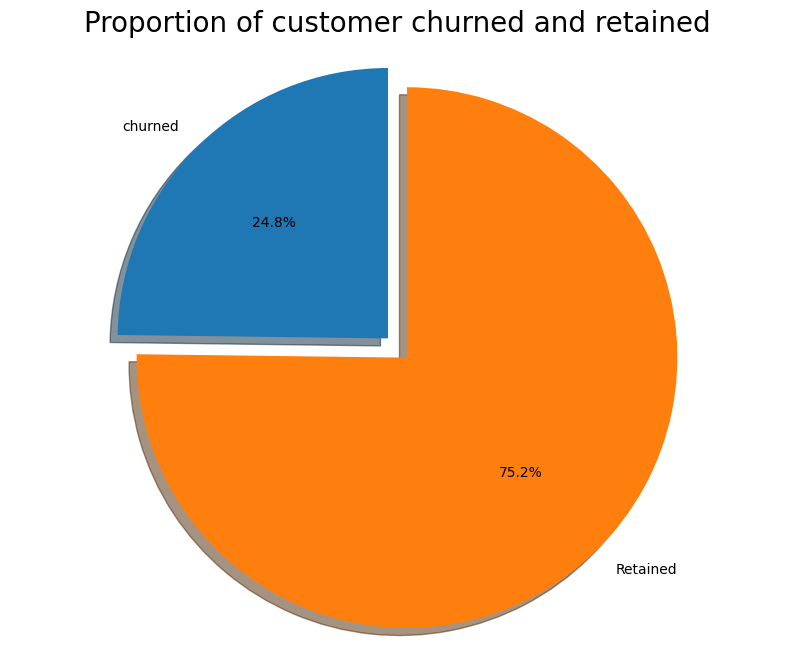

In [517]:
labels = 'churned', 'Retained'
sizes = [df.target[df['target']==1].count(), df.target[df['target']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

### 25% percentage of employee that want to churn , we have an imbalanced classification problem

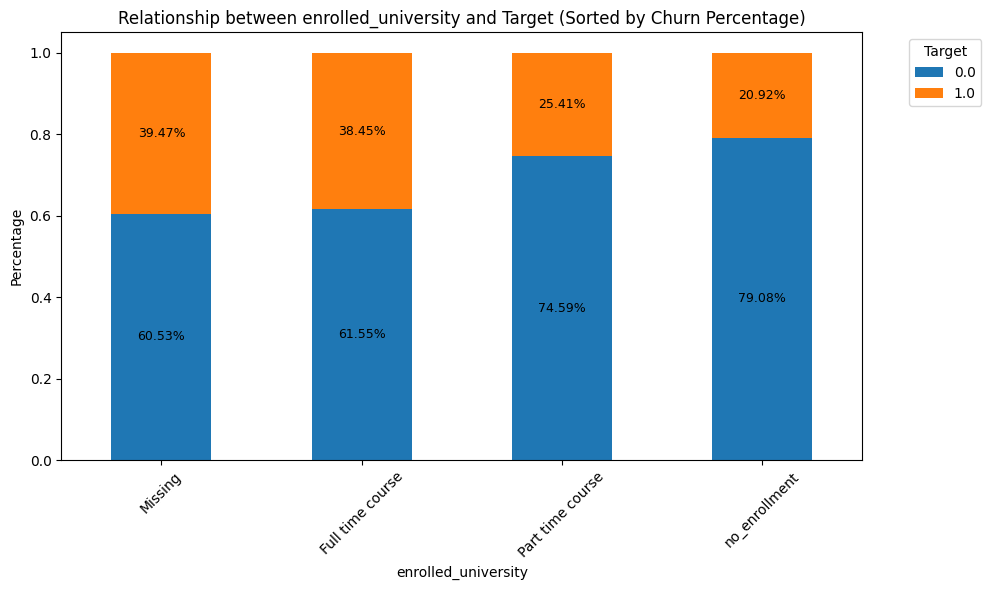

In [518]:
plot_feature_churn(df,'enrolled_university')

### Higher percentage of churning for employees enrolled in a full time course

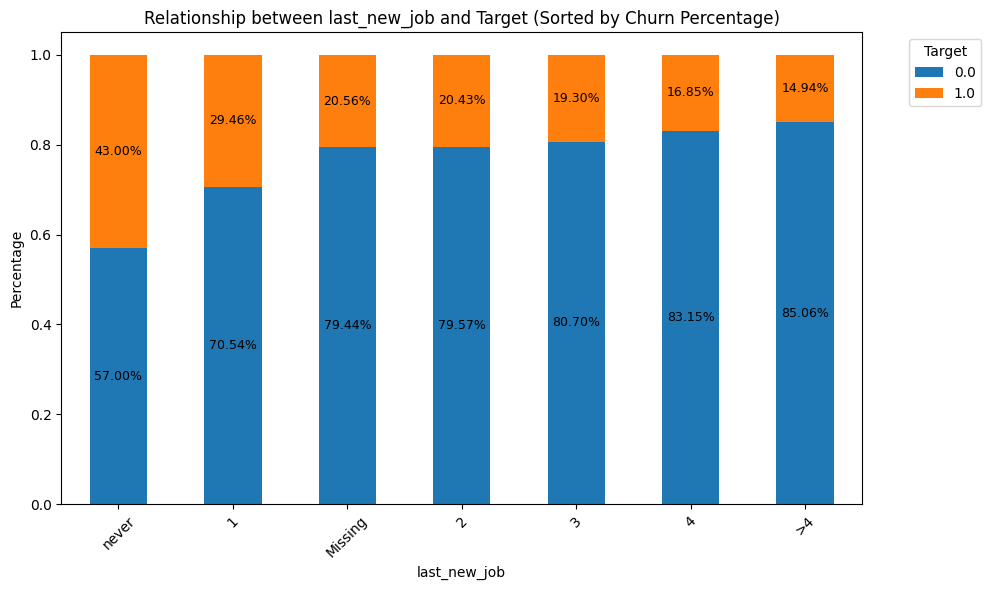

In [519]:
plot_feature_churn(df,'last_new_job')

### Employees that changed job recently are more likely to churn.

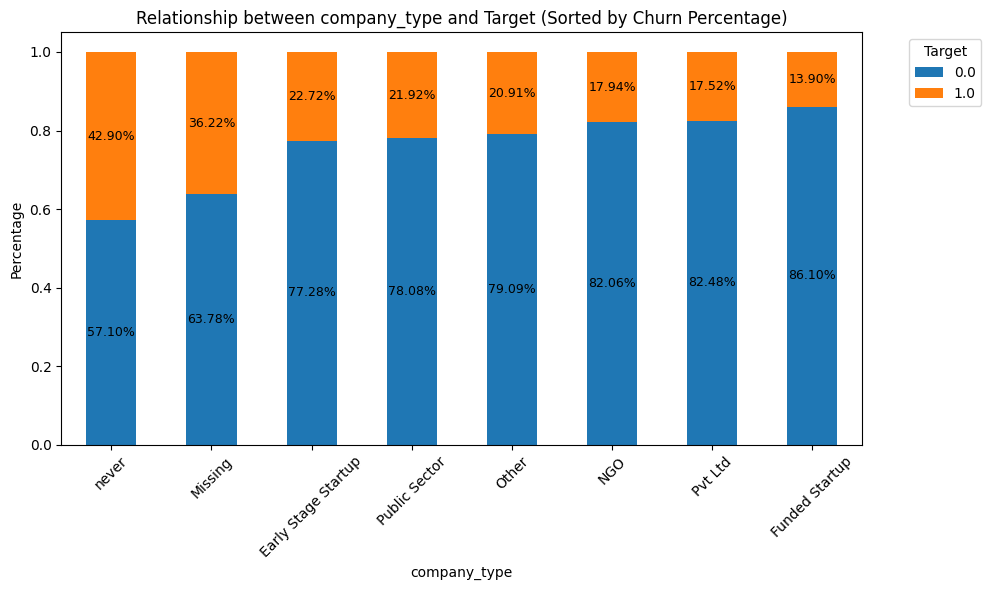

In [520]:
plot_feature_churn(df,'company_type')

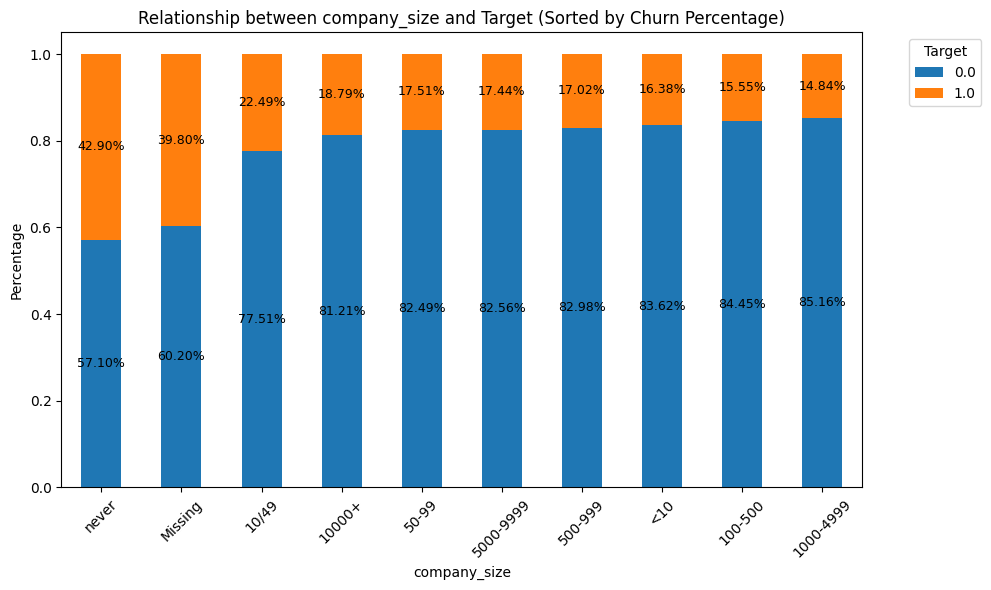

In [521]:
plot_feature_churn(df,'company_size')

### Employees that never had a job before are more likely to churn

In [522]:
print_normalized_groupby(df,'education_level')

,education_level,sum,count,normalized_chrun_rate
0,Graduate,2979.0,10764,0.276756
2,Masters,877.0,4117,0.213019
3,Missing,49.0,239,0.205021
1,High School,359.0,1781,0.201572
4,Phd,58.0,391,0.148338
5,Primary School,22.0,224,0.098214


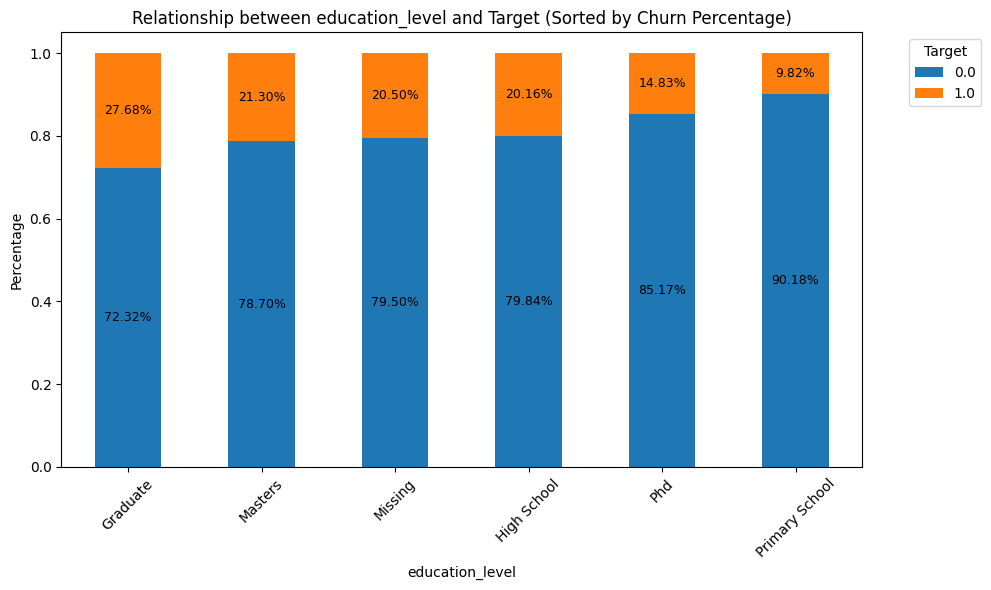

In [523]:
plot_feature_churn(df,'education_level')

### Graduate employees are significantly more likely to churn as compared to other level of education

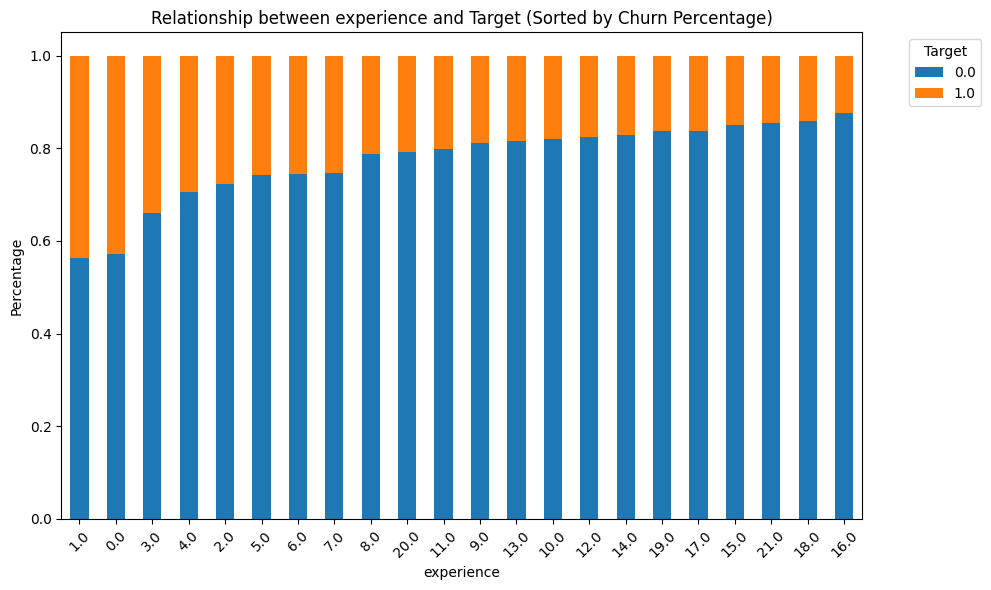

In [524]:
plot_feature_churn(df,'experience', percentage=False)

### experience are highly correlated with probability of churning, the less experience has the employee the more likely they are to churn

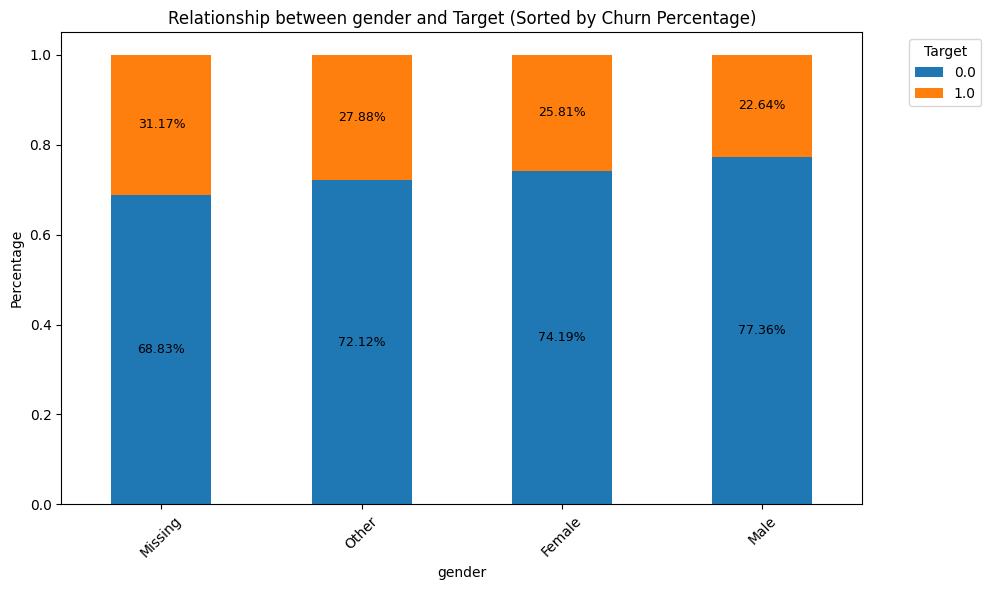

In [528]:
plot_feature_churn(df,'gender')

### Gender is not statisticaly relevant due to bad value counts. 

<Axes: xlabel='target', ylabel='city_development_index'>

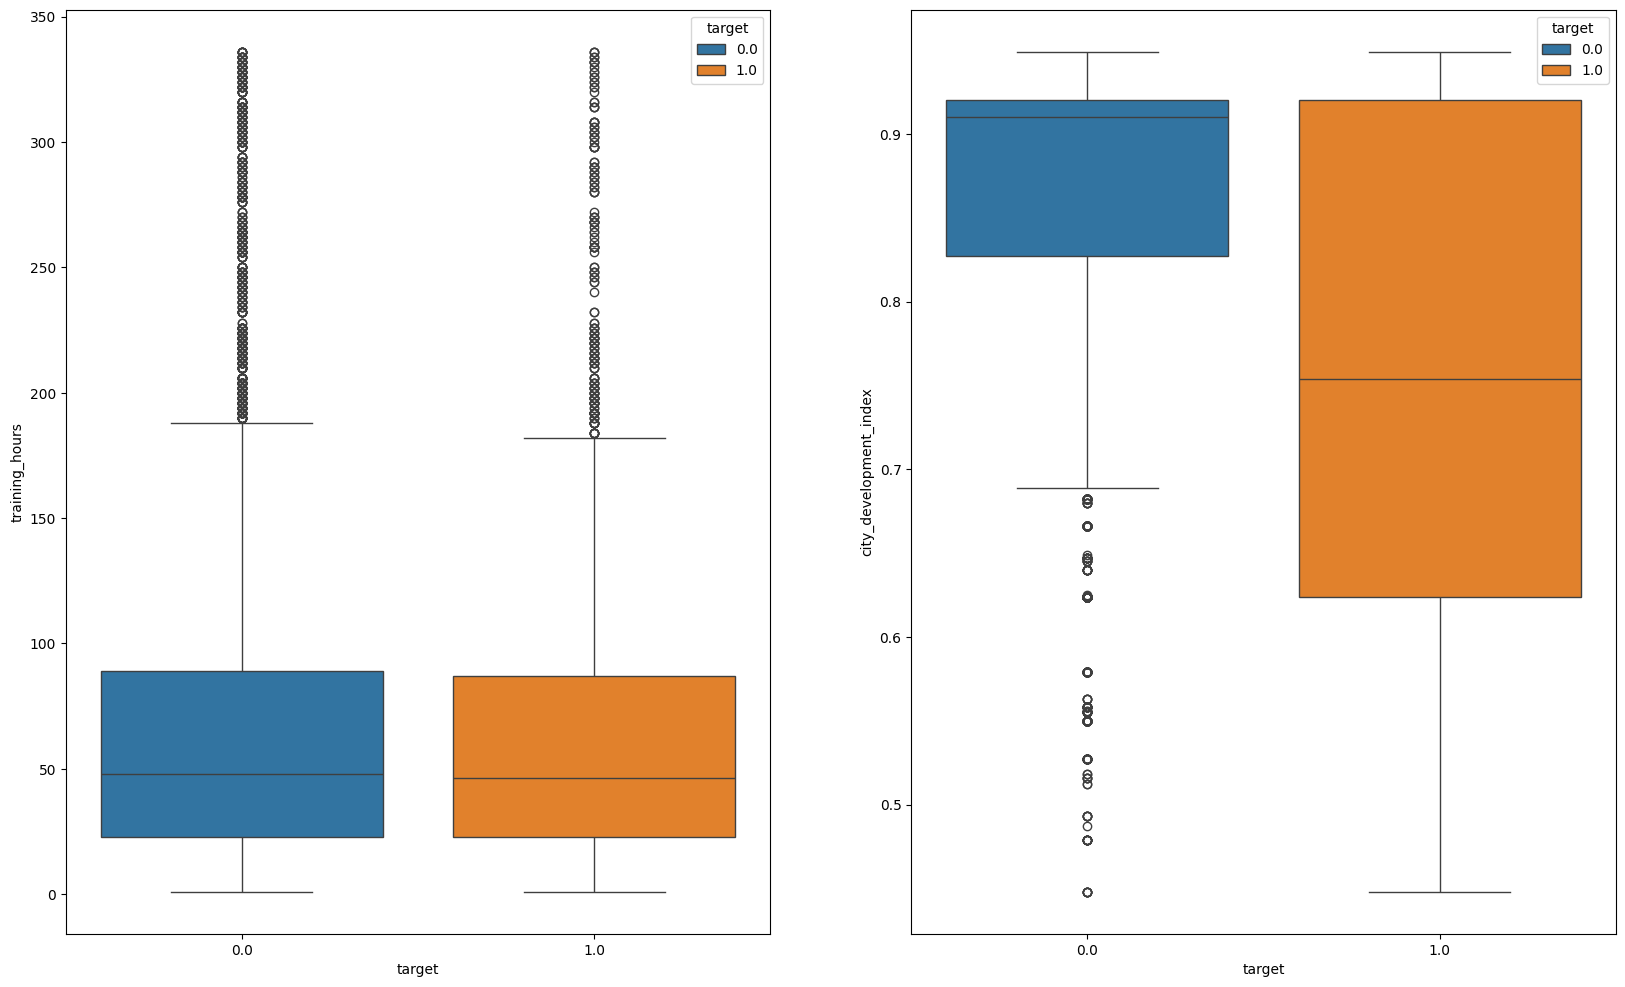

In [529]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(1, 2, figsize=(20, 12))
sns.boxplot(y='training_hours',x = 'target', hue = 'target',data = df, ax=axarr[0])
sns.boxplot(y='city_development_index',x = 'target', hue = 'target',data = df , ax=axarr[1])



We see a significant statisticaly difference between retention and exit in city develompment index, showing clearly that who live in a high developed cities are less likely to churn.

No significant difference between training hours.

## Recap

Abbiamo identificato che i fattori principali che influenzano la decisione di abbandono dei dipendenti sono:

1. **Dipendenti attualmente impegnati in un corso universitario full-time**: Questi dipendenti potrebbero vedere il loro ruolo attuale come temporaneo o meno prioritario rispetto ai loro studi, rendendoli meno impegnati.

2. **Dipendenti che non hanno mai avuto un lavoro**: Questi dipendenti possono essere più propensi a fare churn per via di inssodisfazione e ricerca di un nuovo lavoro.

4. **Dipendenti con bassa esperienza**: La mancanza di esperienza può portare a un aumento della probabilità di fare churn.

5. **Dipendenti che vivono in città con un alto indice di sviluppo**: In queste aree, la disponibilità di più opportunità di lavoro può rendere più facile per i dipendenti trovare alternative, aumentando il churn rate.

6. **Graduated employees**: a differenza degli altri livelli di educazione abbiamo una significativa maggior percentuale di abbandono per i laureati.



-------------

# Challenge 2
Then, a predicting model. You are asked to create a model to predict whether a new employee would churn. Gabriele tells you that he would like to know the probability of churn for each employee, so that he could take corrective actions. Fabio has now joined Pear, and has some advice for you: Gabriele does not believe in black-box models, so be sure to provide him with compelling evidence that your model works.

## FEATURE PROCESSING AND ENGINNERING

In [530]:
df= pd.read_csv("../Data/churn_cleaned.csv")

In [531]:
df.isna().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [532]:
df['target'].value_counts()

target
0.0    13172
1.0     4344
Name: count, dtype: int64

In [533]:
# copia per non modificare
df_cleaned= df.copy()

In [534]:
df_cleaned.dtypes


enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                float64
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [535]:
# non ci interessa l'id del dipendente 
df_cleaned.drop(columns='enrollee_id', inplace=True)

In [536]:
df.shape

(17516, 14)

In [537]:
# Convertiamo le colonne object in categoriche
for column in df_cleaned.select_dtypes(include=['object']).columns:
    df_cleaned[column] = df_cleaned[column].astype('category')

df_cleaned['target'] = df_cleaned['target'].astype('int64')


In [538]:
df_cleaned.dtypes

city                      category
city_development_index     float64
gender                    category
relevent_experience       category
enrolled_university       category
education_level           category
major_discipline          category
experience                 float64
company_size              category
company_type              category
last_new_job              category
training_hours               int64
target                       int64
dtype: object

### TESTEREMO UN PRIMO MODELLO DI CLASSIFICAZIONE PROBABILISTICA CON CATBOOST DATO CHE PUO GESTIRE FEATURE CATEGORICHE E VALORI NaN IN FORMATO STRINGA "Missing" "https://catboost.ai/en/docs/concepts/faq"

In [540]:
X = df_cleaned.drop('target', axis=1)
y = df_cleaned['target']

# Divididiamo il dataset con stratified per garantiche che ci sono valori ecqui di target 1 nel test e train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=200, stratify=y)

print(f"Length of train set: {len(X_train)}, target distribution: \n{y_train.value_counts(normalize=True)}\n")
print(f"Length of test set: {len(X_test)}, target distribution: \n{y_test.value_counts(normalize=True)}")


Length of train set: 13137, target distribution: 
target
0    0.751998
1    0.248002
Name: proportion, dtype: float64

Length of test set: 4379, target distribution: 
target
0    0.751998
1    0.248002
Name: proportion, dtype: float64


In [541]:
# Inizializziamo il CatBoostClassifier
cat_features = X_train.select_dtypes(include=['category']).columns.tolist()

In [542]:
cat_features

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'company_size',
 'company_type',
 'last_new_job']

In [543]:
model = CatBoostClassifier(iterations=1000, 
                           cat_features=cat_features, 
                           verbose=0, 
                           random_seed=200)
#for feature in cat_features:
    # Aggiungi la stringa vuota (o 'Missing') all'elenco delle categorie
    # X_train[feature] = X_train[feature].cat.add_categories([''])

    # # Ora sostituisci NaN con 'Missing'
    # X_train[feature] = X_train[feature].fillna('')

# Crea il Pool di addestramento
train_pool = Pool(data= X_train, label= y_train, cat_features=cat_features)

# Addestra il modello
model.fit(train_pool)

# Crea il Pool di test
test_pool = Pool(X_test, cat_features=cat_features)

# Effettuiamo le previsioni
predictions = model.predict_proba(test_pool)
predictions_proba = predictions[:,1]

In [544]:

# Calcola il log loss
logloss = log_loss(y_test, predictions_proba)

# Calcola il Brier score
brier = brier_score_loss(y_test, predictions_proba)

# Calcola ROC AUC
roc_auc = roc_auc_score(y_test, predictions_proba)

# Calcola la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba)

# Calcola l'area sotto la curva ROC
roc_auc = auc(fpr, tpr)

# Calcola la curva Precision-Recall e AUC
precision, recall, thresholds = precision_recall_curve(y_test, predictions_proba)
pr_auc = auc(recall, precision)

# Stampa le metriche
print(f"Log Loss: {logloss:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")


Log Loss: 0.4340
Brier Score: 0.1382
ROC AUC: 0.8024
Precision-Recall AUC: 0.5474


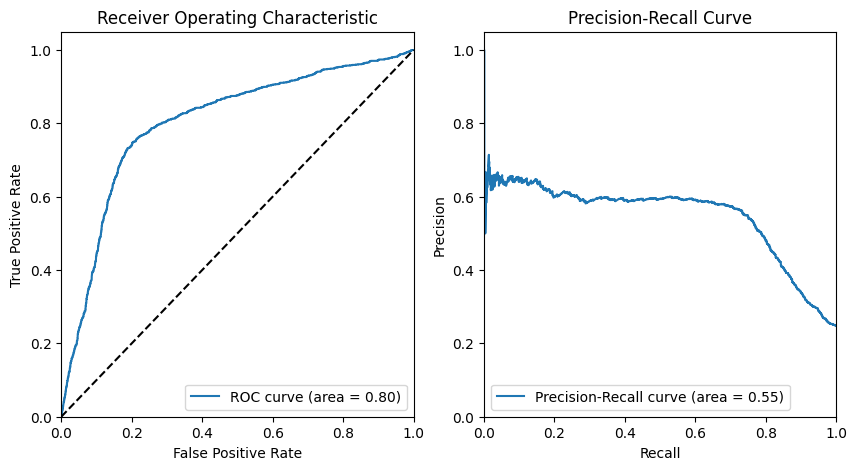

In [545]:
plt.figure(figsize=(10, 5))

# Sottotrama per la curva ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Sottotrama per la curva Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.show()

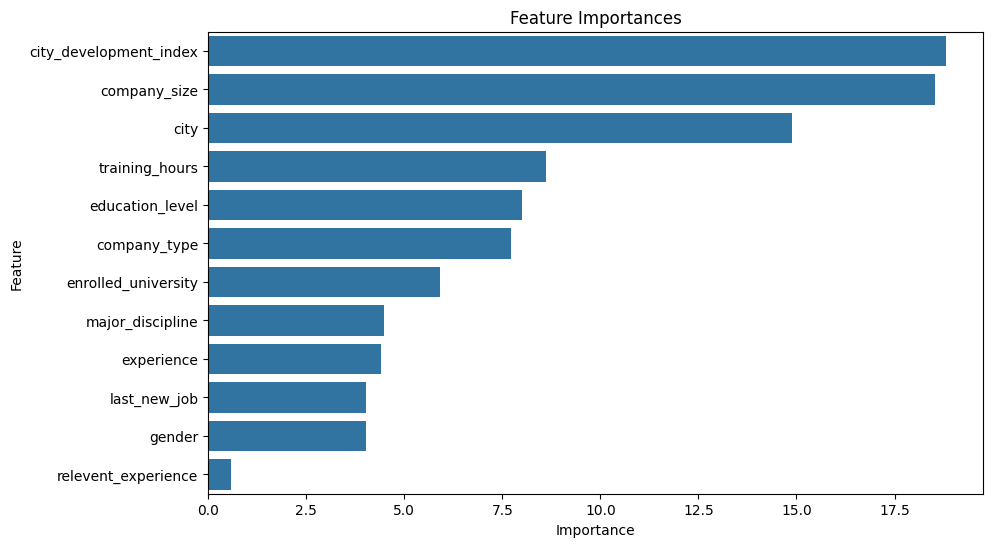

In [546]:
# extract feature importance
feature_importances = model.get_feature_importance()
feature_names = X_train.columns


importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importances = importances.sort_values(by='Importance', ascending=False)

# plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Feature Importances')
plt.show()

In [547]:
df_proba= X_test.copy()
df_proba['true'] = y_test
df_proba['pred'] = predictions_proba

In [615]:
df_proba[['true','pred']].sort_values(by='pred').head(15)

,true,pred
12746,0,0.010300
11115,0,0.011870
9527,0,0.013239
11560,0,0.018203
284,0,0.019566
6609,0,0.019751
12967,0,0.022741
14982,0,0.023220
3158,0,0.023223
5289,0,0.023865


In [616]:
df_proba[['true','pred']].sort_values(by='pred').tail(15)

,true,pred
14541,1,0.719363
12548,1,0.719419
2363,1,0.721426
17316,0,0.722494
15298,1,0.723662
7289,1,0.724720
15633,1,0.724753
14779,0,0.730947
1760,0,0.737125
12441,1,0.742582


### ora possiamo provare modelli differenti o fare un tuning dei iper-parametri

Proviamo con modelli differenti, prima dobbiamo convertire le feature categoriche in numeriche 

In [549]:
df_cleaned

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21.0,Missing,Missing,Missing,36,1
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,>4,47,0
2,city_21,0.624,Missing,No relevent experience,Full time course,Graduate,STEM,0.0,never,never,never,83,0
3,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21.0,50-99,Funded Startup,Missing,8,0
4,city_176,0.764,Missing,Has relevent experience,Part time course,Graduate,STEM,11.0,Missing,Missing,Missing,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17511,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,0.0,never,never,never,42,1
17512,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14.0,Missing,Missing,Missing,52,1
17513,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21.0,50-99,Pvt Ltd,Missing,44,0
17514,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,Missing,0.0,500-999,Pvt Ltd,2,97,0


In [550]:
df['city'].nunique()

122

In [553]:
# Select only columns with data type 'object'
object_columns = df_cleaned.drop(columns='city').select_dtypes(include=['category'])

# Loop through the columns and print the value counts for each one
for column in object_columns:
    print(f"Value counts for {column}:")
    print(object_columns[column].value_counts())
    print("\n")

Value counts for gender:
gender
Male       12290
Missing     3895
Female      1166
Other        165
Name: count, dtype: int64


Value counts for relevent_experience:
relevent_experience
Has relevent experience    12814
No relevent experience      4702
Name: count, dtype: int64


Value counts for enrolled_university:
enrolled_university
no_enrollment       12827
Full time course     3355
Part time course     1106
Missing               228
Name: count, dtype: int64


Value counts for education_level:
education_level
Graduate          10764
Masters            4117
High School        1781
Phd                 391
Missing             239
Primary School      224
Name: count, dtype: int64


Value counts for major_discipline:
major_discipline
STEM               13688
Missing             2044
Humanities           649
Other                357
Business Degree      312
Arts                 242
No Major             224
Name: count, dtype: int64


Value counts for company_size:
company_size
never    

In [574]:
df_processed = df_cleaned.copy()

### feature da trasformare:
- city -> cut "city_" 
- gender -> label_encoding
- relevant experience -> bool (0,1)
- enrolled_university ->  one_hot 
- education_level -> one hot 
- experience -> mapping
- company_size -> label mapping
- company_type -> one_hot
- last_new_job -> label mapping or one hot
- major_discipline -> one hot

### Poiché utilizzeremo modelli basati su alberi decisionali, non dovremo preoccuparci di potenziali interpretazioni errate delle variabili categoriche codificate con Label Encoding.

In [567]:
df_processed.dtypes

city                      category
city_development_index     float64
gender                    category
relevent_experience       category
enrolled_university       category
education_level           category
major_discipline          category
experience                 float64
company_size              category
company_type              category
last_new_job              category
training_hours               int64
target                       int64
dtype: object

In [575]:

# funzione di mapping per experience e last_new_job
"""
def map_experience(x):
    if x == '<1':
        return 0
    elif x == '>20':
        return 21  # rappresenta "più di 20 anni"
    else:
        return float(x)
    """
    
def map_last_new_job(x):
    if x == 'never':
        return 0 
    elif x == '>4':
        return 5  # rappresenta "più di 4 anni"
    elif X == 'Missing':
        return -1
    else:
        return float(x)

# Mappa per company_size con l'Ordinal Encoding
size_mapping = {
    'Missing' : -1,
    'never': 0,
    '<10': 1,
    '10/49': 2,
    '50-99':3,
    '100-500':4,
    '500-999': 5,
    '1000-4999': 6,
    '5000-9999' : 7,
    '10000+': 8,
}

gender_mapping = {
    'Missing' : -1,
    'Other': 0,
    'Male': 1,
    'Female': 2
}


#df_processed['experience'] = df_processed['experience'].apply(map_experience)
#df_processed['last_new_job'] = df_processed['last_new_job'].apply(map_last_new_job)
df_processed['company_size'] = df_processed['company_size'].replace(size_mapping).astype(int)
df_processed['relevent_experience'] = df_processed['relevent_experience'].apply(lambda x: 1 if x == "Has relevent experience" else 0).astype(int)
df_processed['gender'] = df_processed['gender'].replace(gender_mapping).astype(int)


# Applica one-hot encoding
one_hot_cat_columns= ['enrolled_university', 'education_level', 'company_type','major_discipline','last_new_job']
df_processed = pd.get_dummies(df_processed, columns=one_hot_cat_columns)


# Conversione di city in numerica
df_processed['city'] = df_processed['city'].str.replace('city_', '').astype(int)






In [576]:
df_processed.head(20)

,city,city_development_index,gender,relevent_experience,experience,company_size,training_hours,target,enrolled_university_Full time course,enrolled_university_Missing,...,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_Missing,last_new_job_never
0,103,0.920,1,1,21.0,-1,36,1,False,False,...,False,False,True,False,False,False,False,False,True,False
1,40,0.776,1,0,15.0,3,47,0,False,False,...,False,False,True,False,False,False,False,True,False,False
2,21,0.624,-1,0,0.0,0,83,0,True,False,...,False,False,True,False,False,False,False,False,False,True
3,162,0.767,1,1,21.0,3,8,0,False,False,...,False,False,True,False,False,False,False,False,True,False
4,176,0.764,-1,1,11.0,-1,24,1,False,False,...,False,False,True,False,False,False,False,False,True,False
5,160,0.920,1,1,5.0,3,24,0,False,False,...,False,False,False,False,False,False,False,False,True,False
6,46,0.762,1,1,13.0,1,18,1,False,False,...,False,False,True,False,False,False,False,False,True,False
7,103,0.920,1,1,7.0,3,46,1,False,False,...,False,False,True,False,False,False,False,False,True,False
8,103,0.920,-1,1,17.0,8,123,0,False,False,...,False,False,True,False,False,False,False,False,True,False
9,21,0.624,-1,0,0.0,0,32,1,True,False,...,False,False,False,False,False,False,False,False,False,True


In [577]:
df_processed.dtypes

city                                      int32
city_development_index                  float64
gender                                    int32
relevent_experience                       int32
experience                              float64
company_size                              int32
training_hours                            int64
target                                    int64
enrolled_university_Full time course       bool
enrolled_university_Missing                bool
enrolled_university_Part time course       bool
enrolled_university_no_enrollment          bool
education_level_Graduate                   bool
education_level_High School                bool
education_level_Masters                    bool
education_level_Missing                    bool
education_level_Phd                        bool
education_level_Primary School             bool
company_type_Early Stage Startup           bool
company_type_Funded Startup                bool
company_type_Missing                    

In [578]:
df_processed.to_csv("../Data/churn_processed.csv", index=False)
#df_processed = pd.read_csv("../Data/churn_processed.csv")

In [579]:
# columns before and after
df.shape, df_processed.shape

((17516, 14), (17516, 40))

In [580]:
# Definizione dei modelli
models = {
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoostClassifier" : CatBoostClassifier(verbose=0),
    'DecisionTreeClassifier': DecisionTreeClassifier( criterion='gini'),
}


In [587]:
X = df_processed.drop('target', axis=1)
y = df_processed['target']

# Divididiamo il dataset con stratified per garantiche che ci sono valori ecqui di target 1 nel test e train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=200, stratify=y)

# print proportion of target in the train and test set
print(f"Length of train set: {len(X_train)}, target distribution: \n{y_train.value_counts(normalize=True)}\n")
print(f"Length of test set: {len(X_test)}, target distribution: \n{y_test.value_counts(normalize=True)}")


Length of train set: 13137, target distribution: 
target
0    0.751998
1    0.248002
Name: proportion, dtype: float64

Length of test set: 4379, target distribution: 
target
0    0.751998
1    0.248002
Name: proportion, dtype: float64


In [582]:
results = {}

for name, model in models.items():
    # Addestramento del modello
    model.fit(X_train, y_train)

    # Previsioni sul set di test
    predictions = model.predict_proba(X_test)
    predictions_proba = predictions[:,1]

    # Calcolo delle metriche di valutazione
    # Calcola il log loss
    logloss = log_loss(y_test, predictions_proba)

    # Calcola il Brier score
    brier = brier_score_loss(y_test, predictions_proba)

    # Calcola ROC AUC
    roc_auc = roc_auc_score(y_test, predictions_proba)

    # Calcola la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, predictions_proba)

    # Calcola l'area sotto la curva ROC
    roc_auc = auc(fpr, tpr)

    # Calcola la curva Precision-Recall e AUC
    precision, recall, thresholds = precision_recall_curve(y_test, predictions_proba)
    pr_auc = auc(recall, precision)

    # Stampa le metriche
    print(f"Risultati per {name}:")
    print(f"Log Loss: {logloss:.4f}")
    print(f"Brier Score: {brier:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    print("============================================\n")

    # Salvataggio dei risultati
    results[name] = {'logloss': logloss, 'brier': brier, 'ROC AUC': roc_auc,'Precision-Recall AUC':pr_auc}

    
 


Risultati per RandomForest:
Log Loss: 0.5870
Brier Score: 0.1589
ROC AUC: 0.7673
Precision-Recall AUC: 0.5020

Risultati per XGBoost:
Log Loss: 0.4648
Brier Score: 0.1473
ROC AUC: 0.7841
Precision-Recall AUC: 0.5194

Risultati per LightGBM:
Log Loss: 0.4382
Brier Score: 0.1397
ROC AUC: 0.7996
Precision-Recall AUC: 0.5360

Risultati per CatBoostClassifier:
Log Loss: 0.4414
Brier Score: 0.1408
ROC AUC: 0.7988
Precision-Recall AUC: 0.5350

Risultati per DecisionTreeClassifier:
Log Loss: 10.4350
Brier Score: 0.2916
ROC AUC: 0.6117
Precision-Recall AUC: 0.4852



In [585]:
model_tuning = {
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoostClassifier" : CatBoostClassifier(verbose=0),
}

In [588]:
# Espansione dello spazio dei parametri per la Grid Search
param_grid = {
    "LightGBM": {"n_estimators": [100, 200, 300, 400, 500, 600], "learning_rate": [0.01, 0.05, 0.1], "max_depth": [3, 5, 7]},
    "CatBoostClassifier": {"iterations": [100, 200, 300, 400, 500, 600], "learning_rate": [0.01, 0.05, 0.1], "depth": [4, 6, 8]}
}

# Risultati di Grid Search per ogni modello
results = {}

# Esecuzione della Grid Search per ogni modello
for name, model in model_tuning.items():
    try:
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X, y)
        results[name] = {
            "best_params": grid_search.best_params_,
            "best_score": grid_search.best_score_,
            "best_estimator": grid_search.best_estimator_
        }
    except Exception as e:
        print(f"Errore durante la Grid Search per {name}: {e}")

# Stampa dei risultati
for name, result in results.items():
    print(f"Migliori parametri per {name}: {result['best_params']}")
    print(f"Miglior punteggio AUC per {name}: {result['best_score']}")


for name, result in results.items():
    best_model = result['best_estimator']
    predictions = best_model.predict_proba(X_test)
    predictions_proba = predictions[:, 1]
    auc_score = roc_auc_score(y_test, predictions_proba)
    print(f"Punteggio AUC per {name} sul set di test: {auc_score}")


Migliori parametri per LightGBM: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
Miglior punteggio AUC per LightGBM: 0.7991127214254987
Migliori parametri per CatBoostClassifier: {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
Miglior punteggio AUC per CatBoostClassifier: 0.7991660119917221
Punteggio AUC per LightGBM sul set di test: 0.8432119809921039
Punteggio AUC per CatBoostClassifier sul set di test: 0.8414296411999559


--------

# Challenge 3

Your model's a hit, but why does it work wonders? Time to add some transparency to your tech. Make your model interpretable, showcasing the key features and how each prediction is made. Your audience: both Gabriele and Fabio, so balance simplicity with sophistication.

## Feature Importance

Punteggio AUC per LightGBM sul set di test: 0.8432119809921039


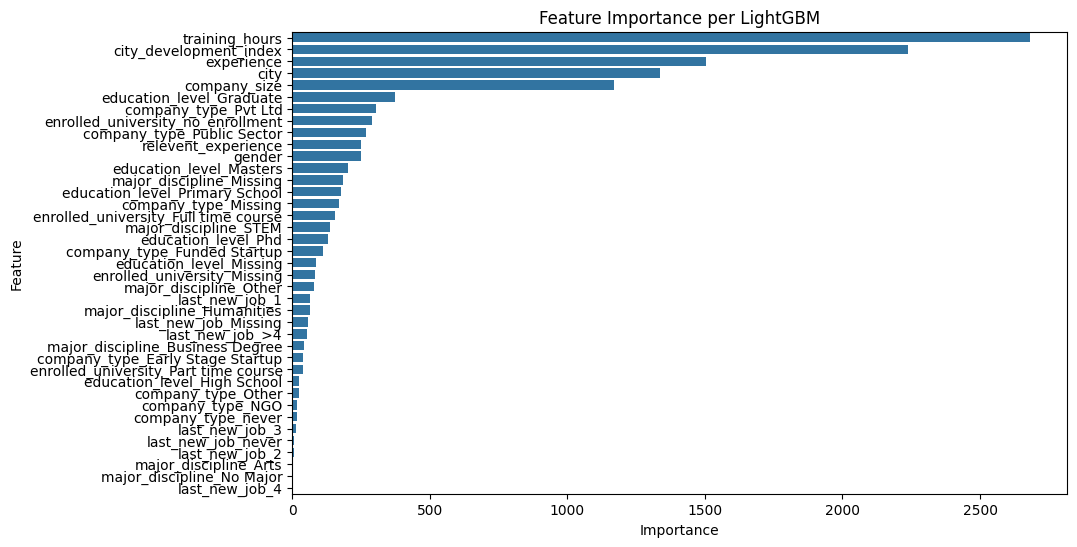

Punteggio AUC per CatBoostClassifier sul set di test: 0.8414296411999559


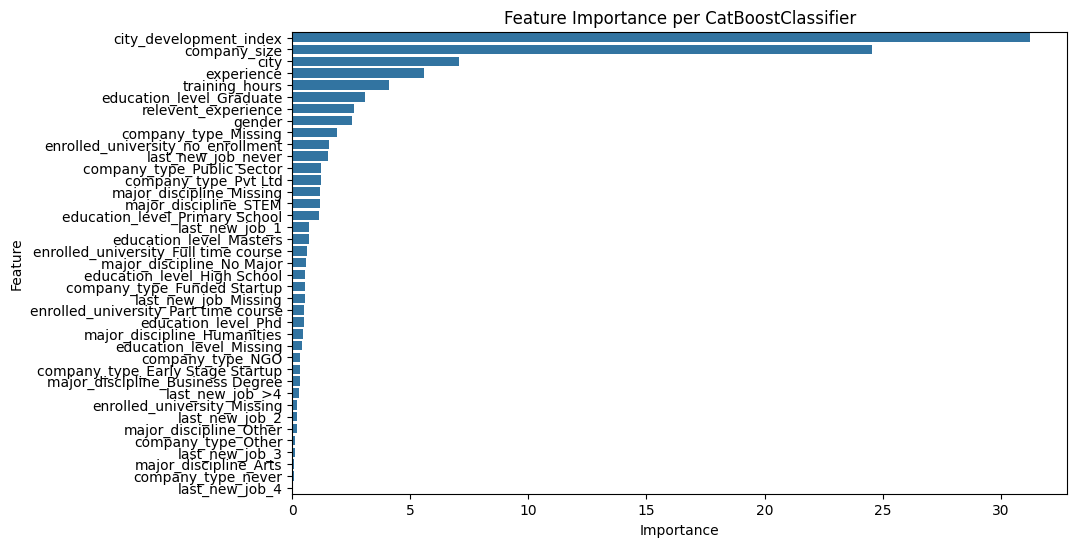

In [589]:
# Funzione per visualizzare la feature importance
def plot_feature_importance(importance, features, model_name):
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values('Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance)
    plt.title(f'Feature Importance per {model_name}')
    plt.show()

# Previsioni sul set di test e valutazione, inclusa la feature importance
features = X_test.columns

for name, result in results.items():
    best_model = result['best_estimator']
    predictions = best_model.predict_proba(X_test)
    predictions_proba = predictions[:, 1]
    auc_score = roc_auc_score(y_test, predictions_proba)
    print(f"Punteggio AUC per {name} sul set di test: {auc_score}")
    
    # Stampa della feature importance se disponibile
    if hasattr(best_model, 'feature_importances_'):
        plot_feature_importance(best_model.feature_importances_, features, name)


Vediamo che le features più rilevanti che i modelli usano per le previsioni sono l'indice di sviluppo della città di residenza, la dimensione della azienda del lavoro precedente, l'esperienza e il numero di ore spesi in formazione.

## Model interpretation

In [590]:
import shap

model = results['LightGBM']['best_estimator']

# Crea un "explainer" SHAP e calcola i valori SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


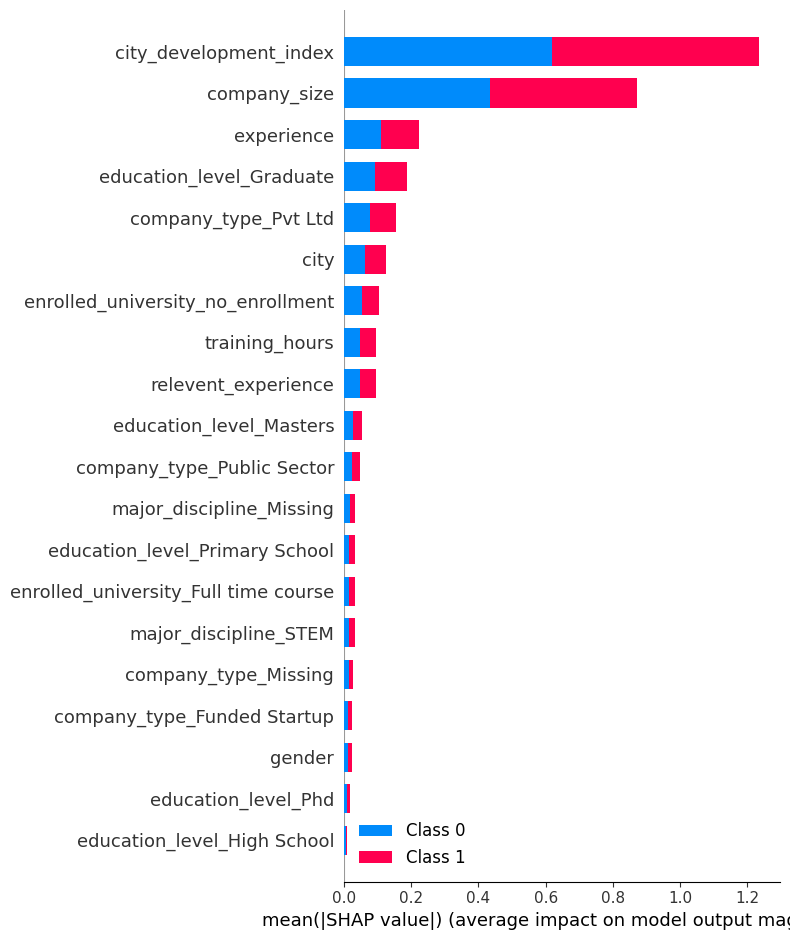

In [591]:
shap.summary_plot(shap_values, X_test)


In [592]:
class_index = 1  # Usare 0 per la classe negativa 

# Seleziona i valori SHAP per la classe desiderata
shap_values_for_class = shap_values[class_index]
shap.initjs()

# Ora puoi creare il force plot per un singolo esempio
shap.force_plot(explainer.expected_value[class_index], shap_values_for_class[0], X_test.iloc[0])



Questo force plot mostra la contribuzione di ogni feature alla predizione di un singolo esempio dal set di test. Le feature che spingono la predizione verso un valore più alto sono mostrate in rosso, mentre quelle che spingono verso un valore più basso sono in blu. Il valore di base (base value) rappresenta la media delle predizioni sul set di dati; in questo caso, è il valore da cui partiamo prima di aggiungere l'effetto di ogni feature. Le barre estese mostrano quanto ogni feature contribuisca all'aumento o alla diminuzione del valore predetto rispetto a questo valore di base. Ad esempio, possiamo vedere che 'company_size = 0' e 'experience = 0' stanno contribuendo a ridurre la predizione, mentre 'education_level_Graduate = 1' sta aumentandola. Questo tipo di visualizzazione è particolarmente utile per comprendere le decisioni del modello su un livello microscopico, offrendo intuizioni sul perché una particolare predizione sia stata fatta.
